##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#### Developed by AI/ML GDE [Nitin Tiwari](https://linkedin.com/in/tiwari-nitin).
* LinkedIn: [linkedin.com/in/tiwari-nitin](https://linkedin.com/in/tiwari-nitin)
* GitHub: [github.com/NSTiwari](https://github.com/NSTiwari)
* X: [@NSTiwari21](https://x.com/NSTiwari21)




This notebook covers Part 2 of the implementation for converting and quantizing the PaliGemma 2 Vision Language Model to ONNX for inference with Transformers.js.

* [Part 1]: [Convert and quantize PaliGemma 2 to ONNX.](https://github.com/google-gemini/gemma-cookbook/blob/main/PaliGemma/[PaliGemma_2]Convert_PaliGemma2_to_ONNX.ipynb)

* [Part 2]: [Inference the converted model using 🤗 Transformers.js for tasks like image captioning, zero-shot object detection, OCR, and visual Q&A.](https://github.com/google-gemini/gemma-cookbook/blob/main/PaliGemma/[PaliGemma_2]Inference_PaliGemma2_with_Transformers_js.ipynb)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/[PaliGemma_2]Inference_PaliGemma2_with_Transformers_js.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


### Select the runtime

To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to load the PaliGemma 2 model. In this case, a T4/L4 GPU would be needed to load the model weights.

1. In the upper-right of the Colab window, click the **▾ (Additional connection options)** dropdown menu.
1. Select **Change runtime type**.
1. Under **Hardware accelerator**, select **T4 or L4**.

### Step 1: Install Node.js

In [ ]:
# Install Node.js
!curl -fsSL https://deb.nodesource.com/setup_20.x | sudo -E bash -
!sudo apt-get install -y nodejs

2025-02-19 21:45:12 - Installing pre-requisites
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,317 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [66.7 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/m

### Step 2: Setup environment
Create a new Node.js project, and configure the package.

In [ ]:
!mkdir paligemma2
%cd paligemma2

# Initialize NPM project.
!npm init -y
!npm i @huggingface/transformers canvas

/content/paligemma2
Wrote to /content/paligemma2/package.json:

{
  "name": "paligemma2",
  "version": "1.0.0",
  "main": "index.js",
  "scripts": {
    "test": "echo \"Error: no test specified\" && exit 1"
  },
  "keywords": [],
  "author": "",
  "license": "ISC",
  "description": ""
}



⠙⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙
added 115 packages, and audited 116 packages in 22s
⠙
⠙27 packages are looking for funding
⠙  run `npm fund` for details
⠙
found 0 vulnerabilities
⠙

In [ ]:
%%writefile package.json

{
  "name": "paligemma2",
  "version": "1.0.0",
  "main": "index.js",
  "type": "module",
  "scripts": {
    "test": "echo \"Error: no test specified\" && exit 1"
  },
  "keywords": [],
  "author": "Nitin Tiwari",
  "license": "MIT",
  "description": "",
  "dependencies": {
    "@huggingface/transformers": "^3.1.2"
  }
}

Overwriting package.json


### Step 3: Inference with Transformers.js
Load the ONNX weights of the PaliGemma 2 model. Next, pass the input image along with the text prompt and then parse the output.

**Example prompts:**

* Object Detection: `<image>detect object-name`
* Image Captioning: `<image>caption en`
* Optical Character Recognition (OCR): `<image>OCR`
* Visual Question Answering (VQA): `<image>What is the color of the person's shirt?`

In [ ]:
!wget -P /content/ https://raw.githubusercontent.com/NSTiwari/PaliGemma2-ONNX-Transformers.js/main/test_images/image_01.png
!wget -P /content/ https://raw.githubusercontent.com/NSTiwari/PaliGemma2-ONNX-Transformers.js/main/test_images/image_02.png
!wget -P /content/ https://raw.githubusercontent.com/NSTiwari/PaliGemma2-ONNX-Transformers.js/main/test_images/image_03.png
!wget -P /content/ https://raw.githubusercontent.com/NSTiwari/PaliGemma2-ONNX-Transformers.js/main/test_images/image_04.png

--2025-02-19 21:45:58--  https://raw.githubusercontent.com/NSTiwari/PaliGemma2-ONNX-Transformers.js/main/test_images/image_01.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109411 (107K) [image/png]
Saving to: ‘/content/image_01.png’

image_01.png        100%[===================>] 106.85K  --.-KB/s    in 0.002s  

2025-02-19 21:45:58 (56.6 MB/s) - ‘/content/image_01.png’ saved [109411/109411]

--2025-02-19 21:45:58--  https://raw.githubusercontent.com/NSTiwari/PaliGemma2-ONNX-Transformers.js/main/test_images/image_02.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP reques

In [ ]:
%%writefile index.js

import { AutoProcessor, PaliGemmaForConditionalGeneration, load_image } from "@huggingface/transformers";
import { createCanvas, loadImage } from "canvas";
import fs from "fs";

function getRandomColor() {
  const r = Math.floor(Math.random() * 256);
  const g = Math.floor(Math.random() * 256);
  const b = Math.floor(Math.random() * 256);
  return `rgb(${r},${g},${b})`;
}

// Load processor and model
const model_id = "NSTiwari/paligemma2-3b-mix-224-onnx";
const processor = await AutoProcessor.from_pretrained(model_id);
const model = await PaliGemmaForConditionalGeneration.from_pretrained(
  model_id,
  {
    dtype: {
      embed_tokens: "fp16", // or 'fp16'
      vision_encoder: "fp16", // or 'q4', 'fp16'
      decoder_model_merged: "q4", // or 'q4f16'
    },
  }
);
// console.log("Model and processor loaded successfully!");

// Prepare inputs for PaliGemma 2.
const image = "/content/image_01.png"; // Path to the image.
const raw_image = await load_image(image); // Load image for PaliGemma 2.

const prompt = "<image>"; // Default prompt.

// Extract the label from the prompt <image>detect <label>.
const labelMatch = prompt.match(/detect (\w+)/);
const label = labelMatch ? labelMatch[1] : "Unknown"; // Default to "Unknown" if no label found.

// Capitalize the first letter of the label.
const capitalizedLabel = label.charAt(0).toUpperCase() + label.slice(1);

const inputs = await processor(raw_image, prompt);
// console.log("Inputs prepared successfully!");

try {
  // Generate a response from the model.
  const response = await model.generate({
    ...inputs,
    max_new_tokens: 100, // Maximum number of tokens to generate.
  });

  // Extract the generated IDs from the response.
  const generatedIds = response.slice(null, [inputs.input_ids.dims[1], null]);

  // Decode the generated IDs to get the answer.
  const decodedAnswer = processor.batch_decode(generatedIds, {
    skip_special_tokens: true,
  });



  if (prompt.includes("<image>detect")) {
    // Parse the response to extract bounding box coordinates.
    const boundingBoxes = decodedAnswer[0].match(/<loc(\d+)>/g);

    if (boundingBoxes && boundingBoxes.length === 4) {
      const coordinates = boundingBoxes.map(tag => parseInt(tag.replace("<loc", "").replace(">", "")));
      const [y1, x1, y2, x2] = coordinates.map(coord => Math.floor(coord));

      // Normalize the bounding box coordinates (scale to actual image dimensions).
      const normX1 = Math.round((x1 / 1024) * raw_image.width);
      const normY1 = Math.round((y1 / 1024) * raw_image.height);
      const normX2 = Math.round((x2 / 1024) * raw_image.width);
      const normY2 = Math.round((y2 / 1024) * raw_image.height);

      console.log("Response: ", decodedAnswer[0]);
      // Log the normalized bounding box coordinates.
      console.log("Normalized Bounding Box:", [normX1, normY1, normX2, normY2]);

      // Load the image again using canvas for drawing.
      const canvasImage = await loadImage(image); // Use the canvas loadImage here
      const canvas = createCanvas(canvasImage.width, canvasImage.height);
      const ctx = canvas.getContext("2d");

      // Draw the original image onto the canvas.
      ctx.drawImage(canvasImage, 0, 0);


      const randomColor = getRandomColor();

      ctx.strokeStyle = randomColor;
      ctx.lineWidth = 5;
      ctx.strokeRect(normX1, normY1, normX2 - normX1, normY2 - normY1);

      const labelPadding = 10;
      const textWidth = ctx.measureText(capitalizedLabel).width;
      const labelWidth = textWidth * 2.5;
      const labelHeight = 30;
      const labelY = normY1 - labelHeight;


      ctx.fillStyle = randomColor;
      ctx.fillRect(normX1, labelY, labelWidth, labelHeight);

      ctx.fillStyle = "white";
      ctx.font = "bold 20px Arial";
      ctx.fillText(capitalizedLabel, normX1 + labelPadding, labelY + labelHeight - labelPadding);

      // Save output image.
      const outputImagePath = "/content/output.jpg";
      const buffer = canvas.toBuffer("image/jpeg");
      fs.writeFileSync(outputImagePath, buffer);

      console.log("Object detected in the image, and saved to", outputImagePath);

    }
    else {
      console.log("Bounding boxes not found for the object.");
    }

  }
  else{
  console.log("Response: ", decodedAnswer[0]);
}

}

catch (error) {
  console.error("Error generating response:", error);
}

Overwriting index.js


#### Overwrite the JS code with input prompt and image

In [ ]:
import re

def update_js_file(image_path, prompt):
    # Read the content of the index.js file
    with open('/content/paligemma2/index.js', 'r') as file:
        js_code = file.read()

    # Replace the lines where prompt and image path are defined
    js_code = re.sub(r'const prompt = ".*";', f'const prompt = "{prompt}";', js_code)
    js_code = re.sub(r'const image = ".*";', f'const image = "{image_path}";', js_code)

    # Write the updated code back to index.js
    with open('/content/paligemma2/index.js', 'w') as file:
        file.write(js_code)

    print(f"index.js has been updated with: \nPrompt: {prompt}\nImage path: {image_path}\n")

### Example 1: Object Detection

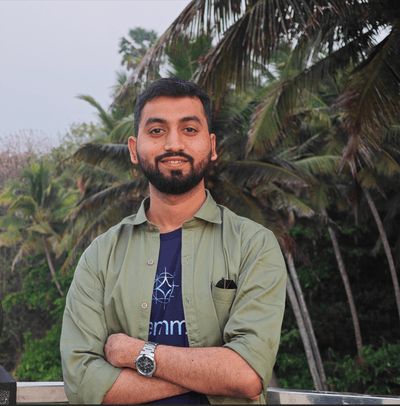

In [ ]:
from PIL import Image
import requests

# Load a sample image.
image_path = "image_01.png" # @param {type: "string"}
image_path = f"/content/{image_path}"

prompt = "detect person" # @param {type: "string"}
prompt = f"<image>{prompt}"

img = Image.open(image_path)
img

index.js has been updated with: 
Prompt: <image>detect person
Image path: /content/image_01.png

Response:  <loc0199><loc0152><loc1021><loc0744> person
Normalized Bounding Box: [ 59, 79, 291, 405 ]
Object detected in the image, and saved to /content/output.jpg


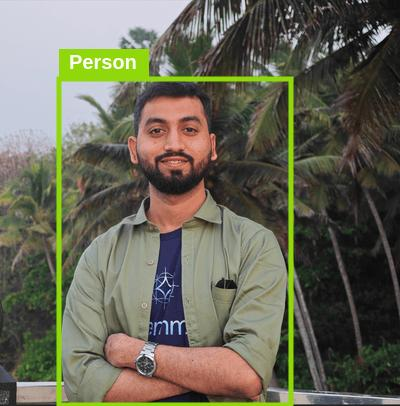

In [ ]:
# Run the Node.js application.
update_js_file(image_path, prompt)
!node index.js

output = Image.open("/content/output.jpg")
display(output)

### Example 2: Captioning

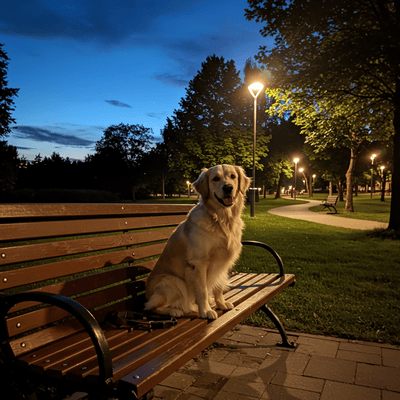

In [ ]:
from PIL import Image
import requests

# Load a sample image.
image_path = "image_02.png" # @param {type: "string"}
image_path = f"/content/{image_path}"

prompt = "caption en" # @param {type: "string"}
prompt = f"<image>{prompt}"

img = Image.open(image_path)
img

In [ ]:
# Run the Node.js application.
update_js_file(image_path, prompt)
!node index.js

index.js has been updated with: 
Prompt: <image>caption en
Image path: /content/image_02.png

Response:  A large dog sits comfortably on a wooden bench in the park, its eyes closed. The setting sun casts long shadows across the green grass, illuminating the street lights and the trees that line the path. The bench is made of wood and has metal arms and legs, and the tree trunk is thick and old. The sky is blue with few clouds, and the street lights cast a warm glow. The dog's coat is light brown, and its paws are on the bench. The tree has green


### Example 3: OCR

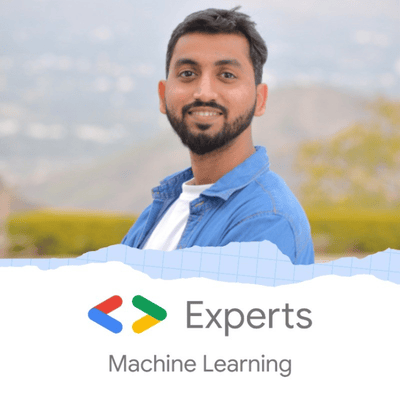

In [ ]:
from PIL import Image
import requests

# Load a sample image.
image_path = "image_03.png" # @param {type: "string"}
image_path = f"/content/{image_path}"

prompt = "OCR" # @param {type: "string"}
prompt = f"<image>{prompt}"

img = Image.open(image_path)
img

In [ ]:
# Run the Node.js application.
update_js_file(image_path, prompt)
!node index.js

index.js has been updated with: 
Prompt: <image>OCR
Image path: /content/image_03.png

Response:  Experts
Machine Learning


### Example 4: Visual Q&A

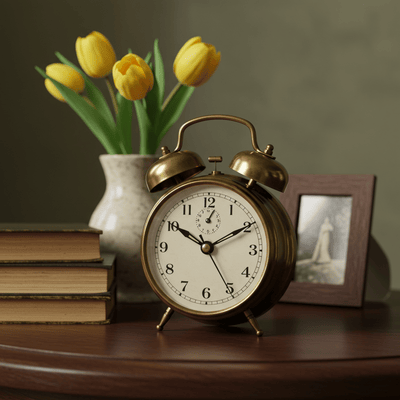

In [ ]:
from PIL import Image
import requests

# Load a sample image.
image_path = "image_04.png" # @param {type: "string"}
image_path = f"/content/{image_path}"

prompt = "What time does the clock show?" # @param {type: "string"}
prompt = f"<image>{prompt}"

img = Image.open(image_path)
img

In [ ]:
# Run the Node.js application.
update_js_file(image_path, prompt)
!node index.js

index.js has been updated with: 
Prompt: <image>What time does the clock show?
Image path: /content/image_04.png

Response:  10:09


Congratulations on successfully running inference with the paligemma2-3b-mix-224 ONNX model with Transformers.js. Be sure to check out this [demo app](https://github.com/google-gemini/gemma-cookbook/tree/main/Demos/PaliGemma2-on-Web) for the web application.